# Imports and utility functions

In [18]:
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import time, glob, gc, os, tifffile, cv2
import pandas as pd
import seaborn as sns
import xarray as xr
import tpae.data.ingest as ti

markers = ['DAPI', 'CLIC5', 'CD34', 'HLADR', 'CD3', 'CD90', 'CD68', 'AF']
real_markers = markers[:-1]
neg_ctrls = markers[-1:]

resolution = 10 # desired size of each pixel in microns
k = 5
repname = f'pca_k={k}_harmony'

datadir = f'../RA/BHAM-data/{resolution}u'
rawdir = f'{datadir}/../_qptiff/'
countsdir = f'{datadir}/counts'
normeddir = f'{datadir}/normalized'
masksdir = f'{datadir}/masks'
processeddir = f'{datadir}/{repname}'

os.makedirs(countsdir, exist_ok=True)
os.makedirs(normeddir, exist_ok=True)
os.makedirs(masksdir, exist_ok=True)
os.makedirs(processeddir, exist_ok=True)

sids = [f.split('/')[-1].split('.qptiff')[0]
        for f in glob.glob(f'{rawdir}/*.qptiff')]

# downsample original images

In [3]:
orig_pixel_size = 0.5
downsample_factor = int(resolution//orig_pixel_size)

In [4]:
for sid in ti.pb(sids):
    f = f'{rawdir}/{sid}.qptiff'
    sample = np.ascontiguousarray(tifffile.TiffFile(f).series[0].asarray().transpose(1,2,0))

    sample = ti.hiresarray_to_downsampledxarray(sample, sid, downsample_factor, orig_pixel_size, markers)
    sample.to_netcdf(f'{countsdir}/{sid}.nc', encoding={sample.name: ti.compression}, engine="netcdf4")
    
    gc.collect()

100%|███████████████████████████████████████████████████████████████| 27/27 [12:44<00:00, 28.30s/it]


# create masks and normalize

reading 300-0529_Scan1
15316 of 3681025 (0%) pixels are non-empty


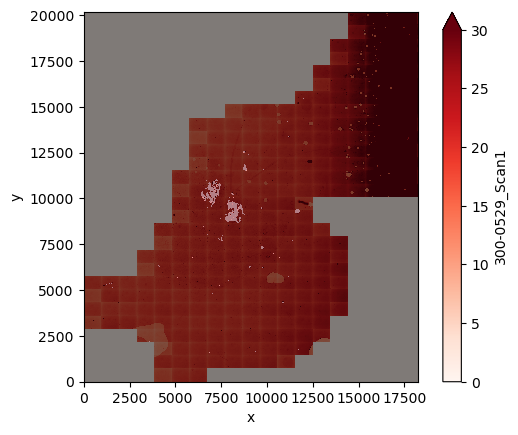

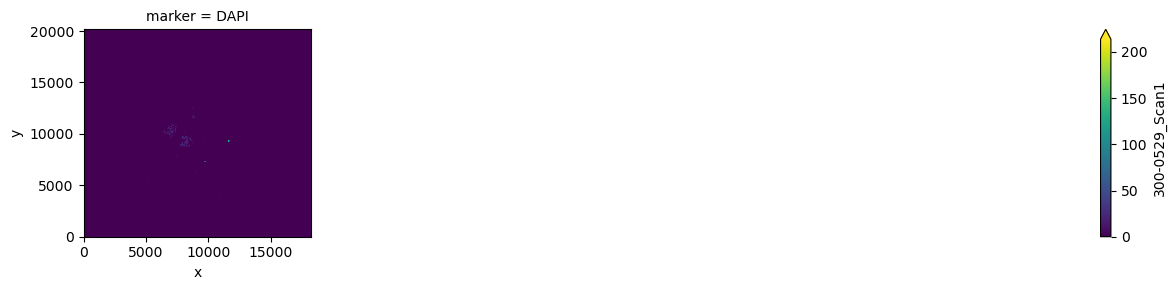

In [19]:
def get_foreground(s):
    if s.name == '300-0529_Scan1':
        s = s.where(s.x < 12500, 0)
    return ti.foreground_mask_ihc(s, real_markers, neg_ctrls, 0.1, 12, blur_width=5)
ti.write_masks(countsdir, masksdir, get_foreground, sids)

In [20]:
def transform(X):
    return (X[:,:-1]) / (1+X[:,-1])[:,None]

def get_sumstats(pixels):
    pixels = transform(pixels)
    ntranscripts = pixels.sum(axis=1, dtype=np.float64)
    med_ntranscripts = np.median(ntranscripts)
    pixels = np.log1p(med_ntranscripts * pixels / (ntranscripts[:,None] + 1e-6)) # adding to denominator in case pixel is all 0s
    means = pixels.mean(axis=0, dtype=np.float64)
    stds = pixels.std(axis=0, dtype=np.float64)
    return {'means':means, 'stds':stds, 'med_ntranscripts':med_ntranscripts}

def normalize(mask, s, med_ntranscripts=None, means=None, stds=None):
    s = s.where(mask, other=0)
    pl = ti.xr_to_pixellist(s, mask)
    pl = transform(pl)
    pl = np.log1p(med_ntranscripts * pl / (pl.sum(axis=1)[:,None] + 1e-6)) # adding to denominator in case pixel is all 0s
    pl -= means
    pl /= stds
    s = s.sel(marker=markers[:-1])
    ti.set_pixels(s, mask, pl)
    s.attrs['med_ntranscripts'] = med_ntranscripts
    s.attrs['means'] = means
    s.attrs['stds'] = stds
    return s

ti.normalize_allsamples(countsdir, masksdir, normeddir, sids,
                               get_sumstats=get_sumstats,
                               normalize=normalize)

reading all non-empty pixels


100%|███████████████████████████████████████████████████████████████| 27/27 [00:07<00:00,  3.51it/s]


computing sumstats
normalizing and writing


100%|███████████████████████████████████████████████████████████████| 27/27 [00:14<00:00,  1.81it/s]


# reduce to k meta-markers using PCA

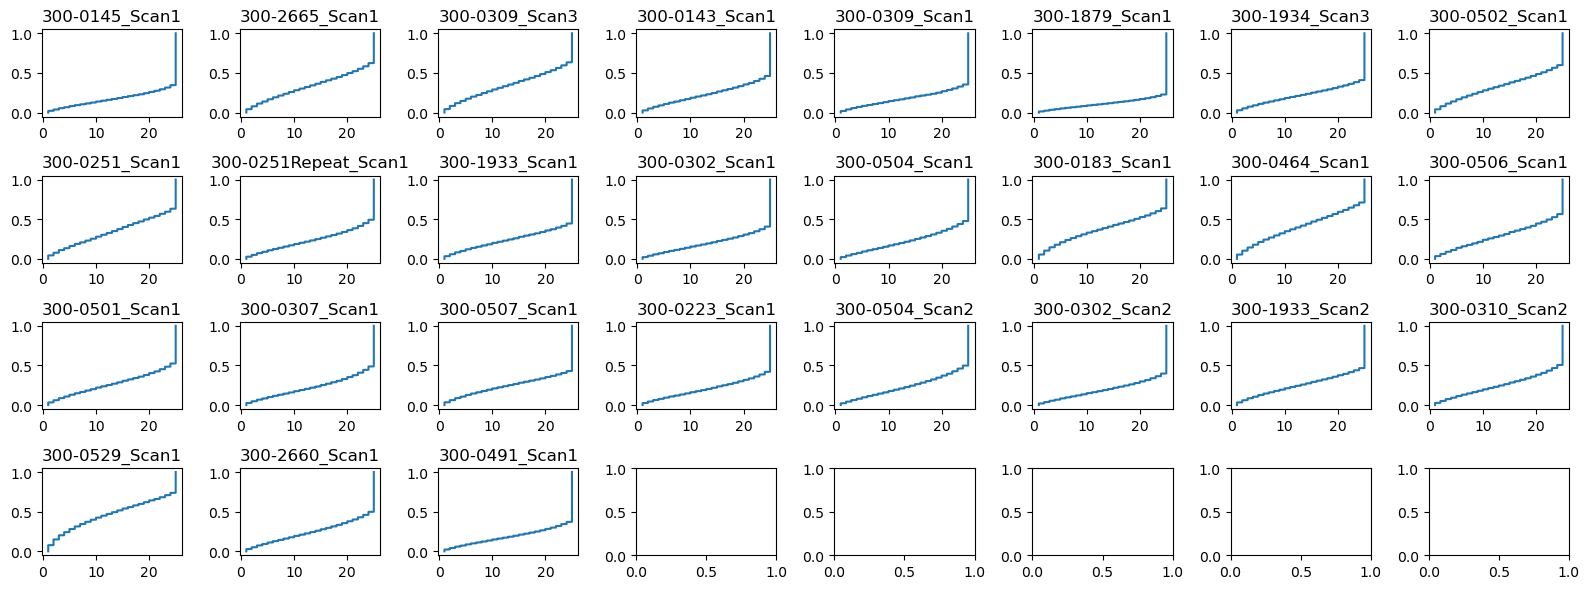

In [21]:
# create metapixels for more accurate PCA
metapixels, npixels = ti.metapixels_allsamples(normeddir, masksdir, sids)

merging and standardizing metapixels


/Users/yakir/miniconda3/envs/torch/lib/python3.12/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/yakir/miniconda3/envs/torch/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


(3306822, 7)
performing PCA


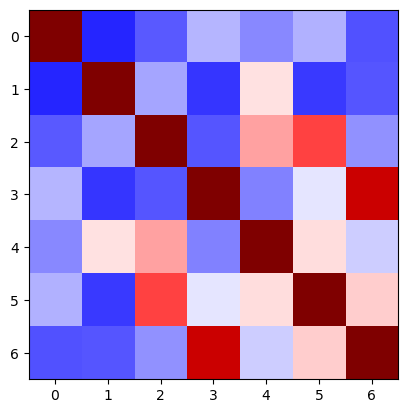

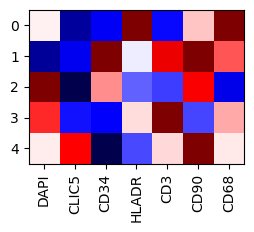

72430

In [22]:
# PCA the metapixels
loadings, C, allmp = ti.pca_metapixels(metapixels.values(), k)
loadings.to_feather(f'{processeddir}/_pcloadings.feather')
del metapixels, allmp; gc.collect()

reading in pixels


100%|███████████████████████████████████████████████████████████████| 27/27 [00:05<00:00,  5.37it/s]


applying dimensionality reduction
visualizing


/Users/yakir/miniconda3/envs/torch/lib/python3.12/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


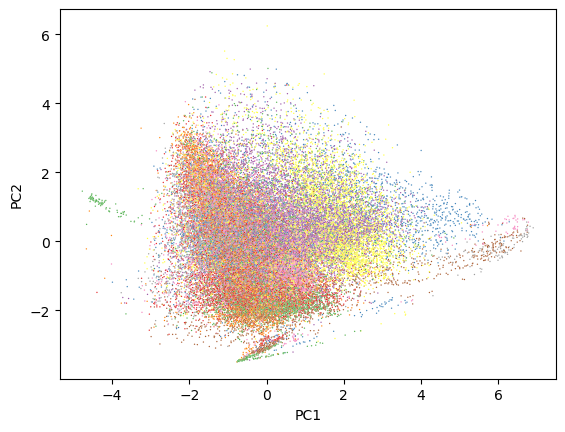

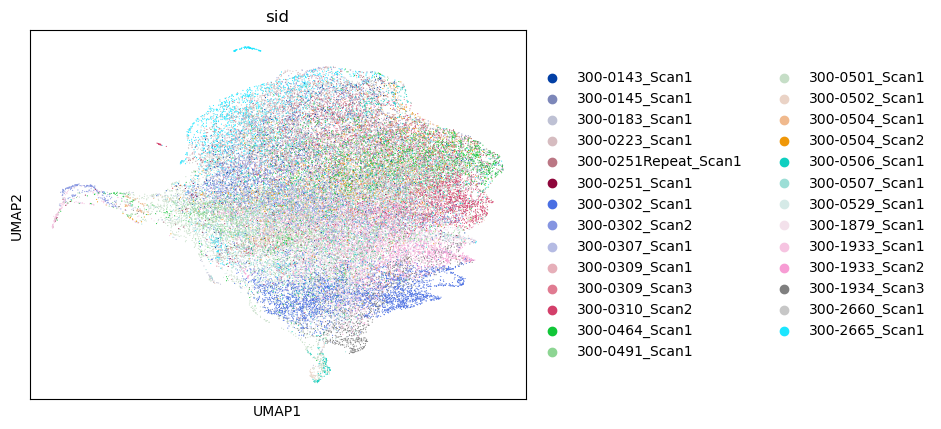

In [23]:
# apply the PC loadings to plain pixels
allpixels_pca = ti.pca_pixels(normeddir, masksdir,
                              pd.read_feather(f'{processeddir}/_pcloadings.feather'), sids)
allpixels_pca.to_feather(f'{processeddir}/_allpixels_pca.feather')

# Run harmony on PCA'd pixels

In [24]:
# run harmony
allpixels_pca = pd.read_feather(f'{processeddir}/_allpixels_pca.feather')
ti.harmonize(allpixels_pca, processeddir)

Please run the following command in your R environment:
Rscript /Users/yakir/Dropbox/py/tpae/data/harmonize.R /Users/yakir/ST/RA/BHAM-data/10u/pca_k=5_harmony/_allpixels_pca.feather sid


/Users/yakir/miniconda3/envs/torch/lib/python3.12/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


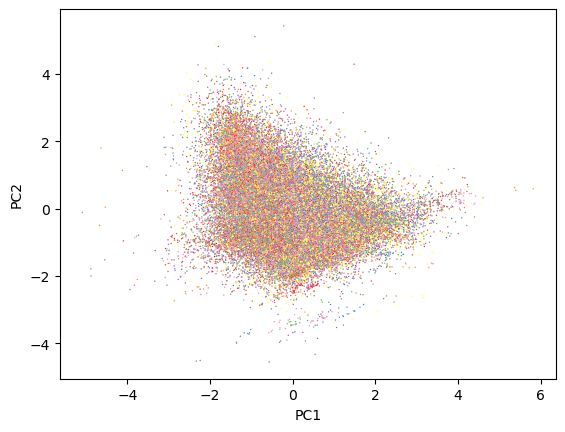

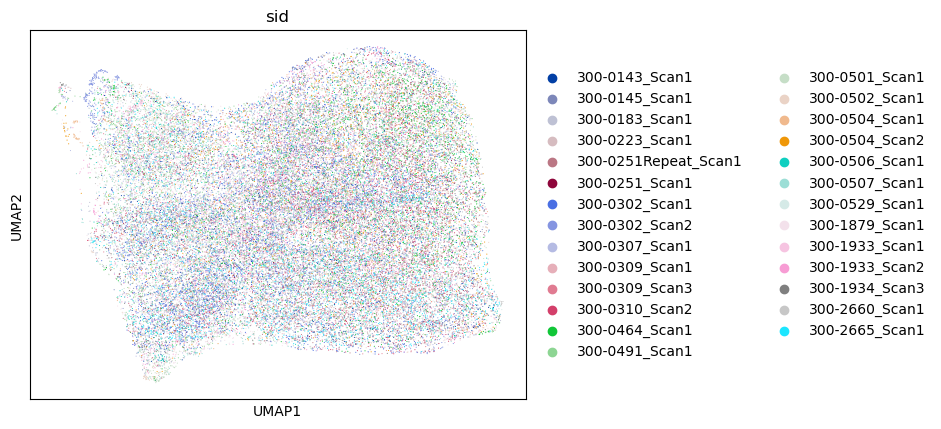

100%|███████████████████████████████████████████████████████████████| 27/27 [00:13<00:00,  2.01it/s]


In [25]:
# read in result and write individual samples
harmpixels = pd.read_feather(f'{processeddir}/_allpixels_pca_harmony.feather')
ti.visualize_pixels(harmpixels, 50000, ['sid'])
ti.write_harmonized(masksdir, processeddir, harmpixels, sids)

# Sanity checks

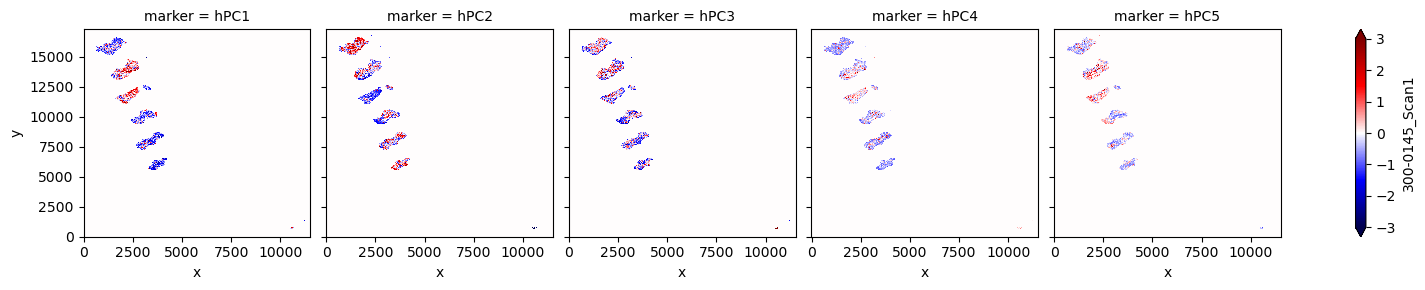

In [26]:
# all pcs of one sample
s = xr.open_dataarray(f'{processeddir}/{sids[0]}.nc').astype(np.float32)
s.plot(col='marker', col_wrap=5, vmin=-3, vmax=3, cmap='seismic')

01234

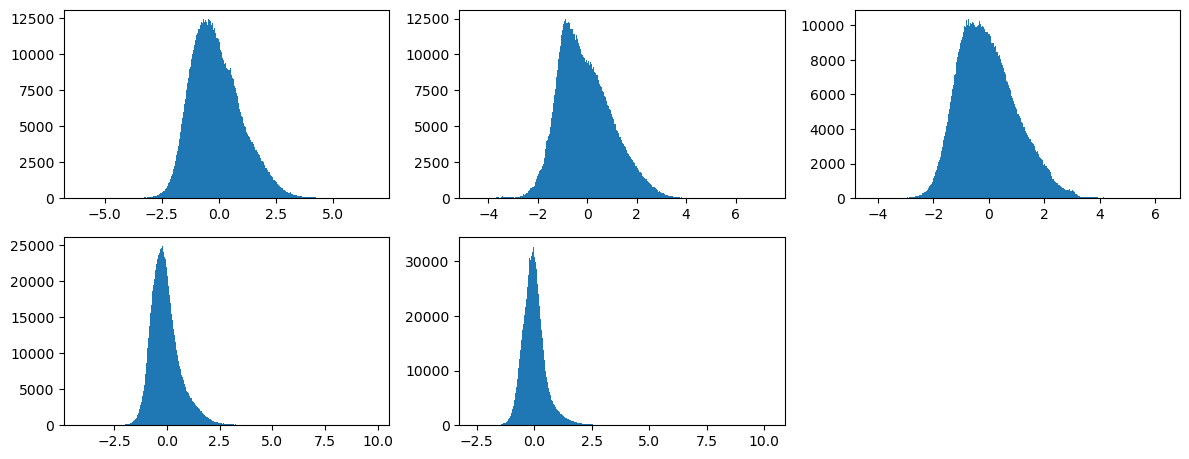

In [27]:
# histogram of each pc
harmpixels = pd.read_feather(f'{processeddir}/_allpixels_pca_harmony.feather')
plt.figure(figsize=(12,9))
for i in range(k):
    print(i, end='')
    plt.subplot(4, 3, i+1)
    plt.hist(harmpixels.values[:,i], bins=1000)
plt.tight_layout()
plt.show()

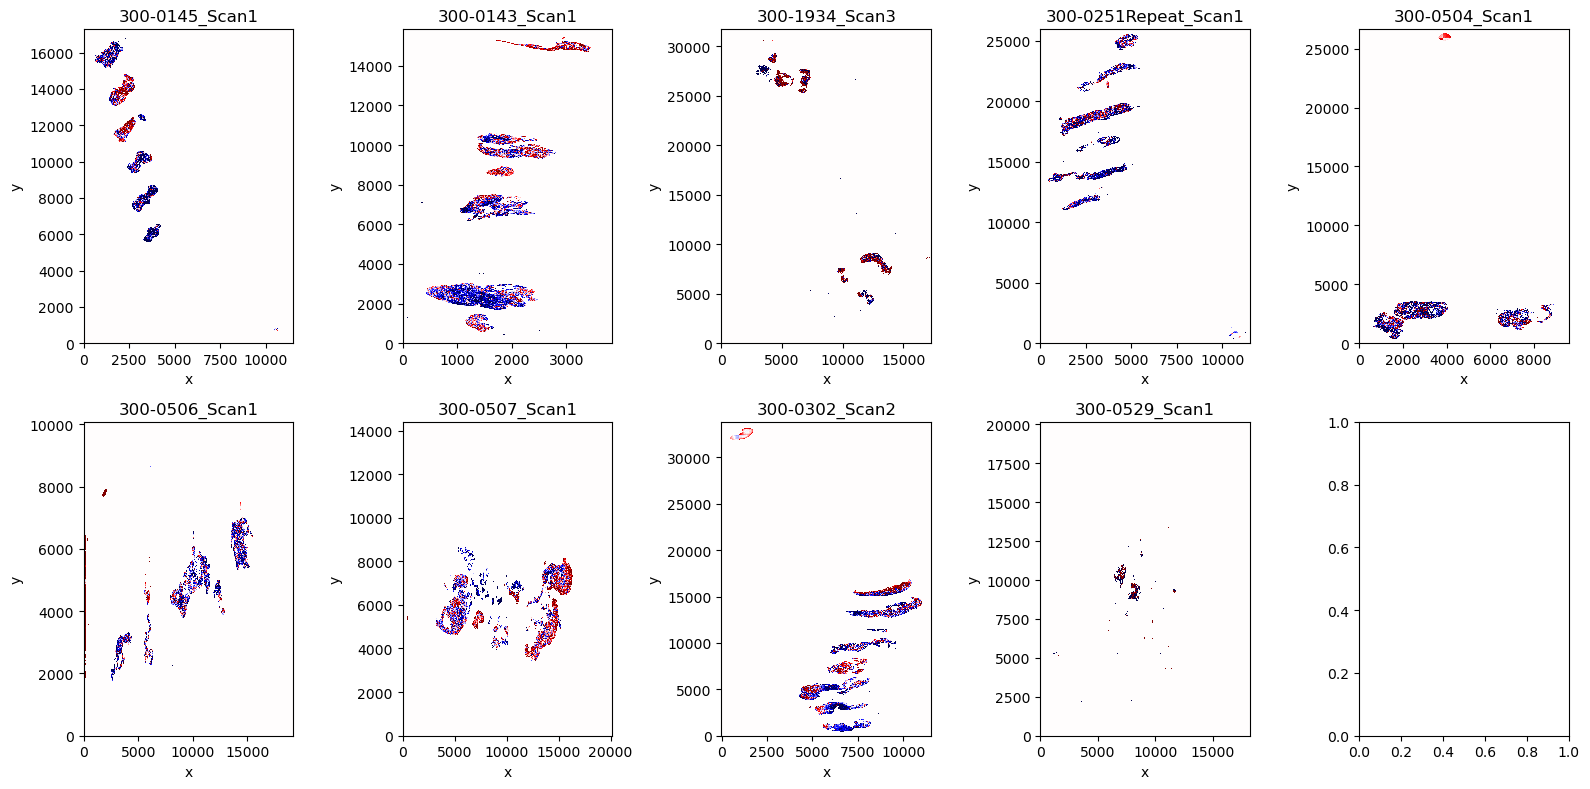

In [28]:
# PC1 of several samples
from IPython.display import display, clear_output
fig, axs = plt.subplots(len(sids[::5])//5 + 1, 5, figsize=(16, 4*(len(sids[::5])//5 + 1)))
for sid, ax in zip(sids[::3], axs.flatten()):
    s = xr.open_dataarray(f'{processeddir}/{sid}.nc').astype(np.float32)
    vmax = np.percentile(np.abs(s.sel(marker='hPC1').data), 99)
    s.sel(marker='hPC1').plot(ax=ax, cmap='seismic', vmin=-vmax, vmax=vmax, add_colorbar=False)
    ax.set_title(sid)
    plt.tight_layout(); clear_output(wait=True); display(fig)
    gc.collect()
plt.close()